## Общие преобразования

Класс для общих случаев

In [1]:
class InsDataFrame:


    ''' Load data method '''

    def load_pd(self, pd_dataframe):
        self._df = pd_dataframe


    ''' Columns match method '''

    def columns_match(self, match_from_to):
        self._df.rename(columns=match_from_to, inplace=True)


    ''' Person data methods '''

    # Gender
    _gender_dict = {'Male':0, 'Female':1}

    def transform_gender(self):
        self._df['Gender'] = self._df['Gender'].map(self._gender_dict)

        

    # Age
    @staticmethod
    def _age(age, age_max):
        if pd.isnull(age):
            age = None
        elif age < 18:
            age = None
        elif age > age_max:
            age = age_max
        return age
      
    def transform_age(self, age_max=70):
        self._df['driver_minage'] = self._df['driver_minage'].apply(self._age, args=(age_max,))

    # Age M/F
    @staticmethod
    def _age_gender(age_gender):
        _age = age_gender[0]
        _gender = age_gender[1]
        if _gender == 0: #Male
            _driver_minage_m = _age
            _driver_minage_f = 18
        elif _gender == 1: #Female
            _driver_minage_m = 18
            _driver_minage_f = _age
        else:
            _driver_minage_m = 18
            _driver_minage_f = 18
        return [_driver_minage_m, _driver_minage_f]
    
    def transform_age_gender(self):
        self._df['driver_minage_m'],self._df['driver_minage_f'] = zip(*self._df[['driver_minage','Gender']].apply(self._age_gender, axis=1).to_frame()[0])

    # Experience
    @staticmethod
    def _exp(exp, exp_max):
        if pd.isnull(exp):
            exp = None
        elif exp < 0:
            exp = None
        elif exp > exp_max:
            exp = exp_max
        return exp

    def transform_exp(self, exp_max=52):
        self._df['driver_minexp'] = self._df['driver_minexp'].apply(self._exp, args=(exp_max,))


    ''' Other data methods '''

    def polynomizer(self, column, n=2):
        if column in list(self._df.columns):
            for i in range(2,n+1):
                self._df[column+'_'+str(i)] = self._df[column]**i

    def get_dummies(self, columns):
        self._df = pd.get_dummies(self._df, columns=columns)


    ''' General methods '''

    def info(self):
        return self._df.info()

    def head(self, columns, n=5):
        return self._df.head(n)

    def len(self):
        return len(self._df)

    def get_pd(self, columns):
        return self._df[columns]

In [2]:
class InsDataFrame_Fr(InsDataFrame):

    # Experience (weeks to years)
    @staticmethod
    def _exp(exp, exp_max):
        if pd.isnull(exp):
            exp = None
        elif exp < 0:
            exp = None
        else:
            exp * 7 // 365
        if exp > exp_max:
            exp = exp_max
        return exp

    # Marital status
    _MariStat_dict = {'Other':0, 'Alone':1}

    def transform_MariStat(self):
        self._df['MariStat'] = self._df['MariStat'].map(self._MariStat_dict)
    
    # Social category
    def transform_SocioCateg(self):
        self._df['SocioCateg'] = self._df['SocioCateg'].str.slice(0,4)

### * Домашнее задание: Многоклассовая классификация

В текущем домашнем задание предлагается взглянуть на задачу моделирования количества страховых случаев как на задачу многоклассовой классификации.

In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval, fmin

In [4]:
df = pd.read_csv('freMPL-R.csv', low_memory=False)

In [5]:
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           115155 non-null  float64
 1   LicAge             115155 non-null  int64  
 2   RecordBeg          115155 non-null  object 
 3   RecordEnd          59455 non-null   object 
 4   Gender             115155 non-null  object 
 5   MariStat           115155 non-null  object 
 6   SocioCateg         115155 non-null  object 
 7   VehUsage           115155 non-null  object 
 8   DrivAge            115155 non-null  int64  
 9   HasKmLimit         115155 non-null  int64  
 10  BonusMalus         115155 non-null  int64  
 11  ClaimAmount        115155 non-null  float64
 12  ClaimInd           115155 non-null  int64  
 13  ClaimNbResp        115155 non-null  float64
 14  ClaimNbNonResp     115155 non-null  float64
 15  ClaimNbParking     115155 non-null  float64
 16  Cl

In [6]:
df

,Exposure,LicAge,RecordBeg,RecordEnd,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,ClaimNbResp,ClaimNbNonResp,ClaimNbParking,ClaimNbFireTheft,ClaimNbWindscreen,OutUseNb,RiskArea
0,0.083,332,2004-01-01,2004-02-01,Male,Other,CSP50,Professional,46,0,50,0.000000,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0
1,0.916,333,2004-02-01,NaN,Male,Other,CSP50,Professional,46,0,50,0.000000,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0
2,0.550,173,2004-05-15,2004-12-03,Male,Other,CSP50,Private+trip to office,32,0,68,0.000000,0,0.0,2.0,0.0,0.0,0.0,0.0,7.0
3,0.089,364,2004-11-29,NaN,Female,Other,CSP55,Private+trip to office,52,0,50,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4,0.233,426,2004-02-07,2004-05-01,Male,Other,CSP60,Private,57,0,50,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115150,0.423,238,2004-07-29,NaN,Male,Other,CSP50,Private+trip to office,39,0,50,0.000000,0,0.0,0.0,0.0,0.0,0.0,4.0,8.0
115151,1.000,408,2004-01-01,NaN,Female,Other,CSP55,Private+trip to office,54,0,50,2764.169184,1,0.0,0.0,0.0,0.0,1.0,0.0,7.0
115152,0.805,211,2004-03-11,NaN,Male,Other,CSP55,Private+trip to office,35,0,54,0.000000,0,0.0,0.0,1.0,0.0,0.0,0.0,7.0
115153,0.538,356,2004-01-01,2004-07-15,Male,Other,CSP50,Private,52,0,50,0.000000,0,0.0,0.0,0.0,0.0,2.0,0.0,7.0


Предобработайте данные

In [7]:
NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
NegClaimAmount.head()

Unique values of ClaimInd: [0]


,ClaimAmount,ClaimInd
82,-74.206042,0
175,-1222.585196,0
177,-316.288822,0
363,-666.758610,0
375,-1201.600604,0


In [8]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

In [9]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [10]:
pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)

,Policies
0.0,104286
2.0,3529
1.0,3339
3.0,2310
4.0,1101
5.0,428
6.0,127
7.0,26
8.0,6
9.0,2


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Exposure     115155 non-null  float64
 1   LicAge       115155 non-null  int64  
 2   RecordBeg    115155 non-null  object 
 3   RecordEnd    59455 non-null   object 
 4   Gender       115155 non-null  object 
 5   MariStat     115155 non-null  object 
 6   SocioCateg   115155 non-null  object 
 7   VehUsage     115155 non-null  object 
 8   DrivAge      115155 non-null  int64  
 9   HasKmLimit   115155 non-null  int64  
 10  BonusMalus   115155 non-null  int64  
 11  ClaimAmount  115155 non-null  float64
 12  ClaimInd     115155 non-null  int64  
 13  OutUseNb     115155 non-null  float64
 14  RiskArea     115155 non-null  float64
 15  ClaimsCount  115155 non-null  float64
dtypes: float64(5), int64(5), object(6)
memory usage: 14.1+ MB


In [12]:
data = InsDataFrame_Fr()
data.load_pd(df)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Exposure     115155 non-null  float64
 1   LicAge       115155 non-null  int64  
 2   RecordBeg    115155 non-null  object 
 3   RecordEnd    59455 non-null   object 
 4   Gender       115155 non-null  object 
 5   MariStat     115155 non-null  object 
 6   SocioCateg   115155 non-null  object 
 7   VehUsage     115155 non-null  object 
 8   DrivAge      115155 non-null  int64  
 9   HasKmLimit   115155 non-null  int64  
 10  BonusMalus   115155 non-null  int64  
 11  ClaimAmount  115155 non-null  float64
 12  ClaimInd     115155 non-null  int64  
 13  OutUseNb     115155 non-null  float64
 14  RiskArea     115155 non-null  float64
 15  ClaimsCount  115155 non-null  float64
dtypes: float64(5), int64(5), object(6)
memory usage: 14.1+ MB


In [13]:
# Переименовываем
data.columns_match({'DrivAge':'driver_minage','LicAge':'driver_minexp'})
# Преобразовываем
data.transform_age()
data.transform_exp()
data.transform_gender()
data.transform_MariStat()
data.transform_SocioCateg()
# Пересечение пола и возраста, их квадраты
data.transform_age_gender()
data.polynomizer('driver_minage_m')
data.polynomizer('driver_minage_f')
# Onehot encoding
data.get_dummies(['VehUsage','SocioCateg'])

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 29 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Exposure                         115155 non-null  float64
 1   driver_minexp                    115155 non-null  int64  
 2   RecordBeg                        115155 non-null  object 
 3   RecordEnd                        59455 non-null   object 
 4   Gender                           115155 non-null  int64  
 5   MariStat                         115155 non-null  int64  
 6   driver_minage                    115155 non-null  int64  
 7   HasKmLimit                       115155 non-null  int64  
 8   BonusMalus                       115155 non-null  int64  
 9   ClaimAmount                      115155 non-null  float64
 10  ClaimInd                         115155 non-null  int64  
 11  OutUseNb                         115155 non-null  float64
 12  Ri

In [15]:
col_features = [
                'driver_minexp',
                'Gender',
                'MariStat',
                'HasKmLimit',
                'BonusMalus',
                'OutUseNb',
                'RiskArea',
                'driver_minage_m',
                'driver_minage_f',
                'driver_minage_m_2',
                'driver_minage_f_2',
                'VehUsage_Private',
                'VehUsage_Private+trip to office',
                'VehUsage_Professional',
                'VehUsage_Professional run',
                'SocioCateg_CSP1',
                'SocioCateg_CSP2',
                'SocioCateg_CSP3',
                'SocioCateg_CSP4',
                'SocioCateg_CSP5',
                'SocioCateg_CSP6',
                'SocioCateg_CSP7'  
]
col_target = [ 'ClaimsCount']
df_class = data.get_pd(col_features+col_target)


In [16]:
df_class

,driver_minexp,Gender,MariStat,HasKmLimit,BonusMalus,OutUseNb,RiskArea,driver_minage_m,driver_minage_f,driver_minage_m_2,...,VehUsage_Professional,VehUsage_Professional run,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,ClaimsCount
0,52,0,0,0,50,0.0,9.0,46,18,2116,...,1,0,0,0,0,0,1,0,0,0.0
1,52,0,0,0,50,0.0,9.0,46,18,2116,...,1,0,0,0,0,0,1,0,0,0.0
2,52,0,0,0,68,0.0,7.0,32,18,1024,...,0,0,0,0,0,0,1,0,0,0.0
3,52,1,0,0,50,0.0,8.0,18,52,324,...,0,0,0,0,0,0,1,0,0,0.0
4,52,0,0,0,50,0.0,7.0,57,18,3249,...,0,0,0,0,0,0,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115150,52,0,0,0,50,4.0,8.0,39,18,1521,...,0,0,0,0,0,0,1,0,0,0.0
115151,52,1,0,0,50,0.0,7.0,18,54,324,...,0,0,0,0,0,0,1,0,0,2.0
115152,52,0,0,0,54,0.0,7.0,35,18,1225,...,0,0,0,0,0,0,1,0,0,0.0
115153,52,0,0,0,50,0.0,7.0,52,18,2704,...,0,0,0,0,0,0,1,0,0,0.0


XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Заменим значение 11 на 10.

In [17]:
df_class.loc[df_class['ClaimsCount']==11, 'ClaimsCount']=10

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Посмотрим, сколько полисов соответствуют каждому из значений `ClaimsCount`, используя метод `groupby`. Для полученных значений также посчитаем нормированную частоту.

In [18]:
df['PolicyCount']=1

In [19]:
FreqCount = pd.DataFrame(df[['Exposure','PolicyCount']].groupby(df['ClaimsCount']).sum())
FreqCount

,Exposure,PolicyCount
ClaimsCount,,
0.0,44362.363,104286
1.0,2023.495,3339
2.0,2134.884,3529
3.0,1382.924,2310
4.0,641.562,1101
5.0,245.889,428
6.0,73.609,127
7.0,13.378,26
8.0,2.882,6


In [20]:
FreqCount['Freq'] = FreqCount['Exposure']/FreqCount['PolicyCount']

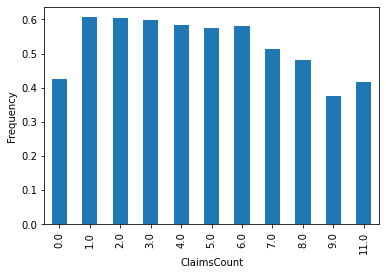

In [21]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

In [22]:
FreqCount

,Exposure,PolicyCount,Freq
ClaimsCount,,,
0.0,44362.363,104286,0.425391
1.0,2023.495,3339,0.606018
2.0,2134.884,3529,0.604954
3.0,1382.924,2310,0.598668
4.0,641.562,1101,0.582708
5.0,245.889,428,0.574507
6.0,73.609,127,0.579598
7.0,13.378,26,0.514538
8.0,2.882,6,0.480333


Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.05` для значений `ClaimsCount` 0, а для остальных - 1 (Для этого можем использовать функцию `np.where`). Также можно попробовать какой-либо другой способ задания весов, приведенный пример не гарантирует хороших результатов.

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [24]:
y=df_class['ClaimsCount']
X=df_class.drop('ClaimsCount', axis=1)

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test,y_test,test_size=0.3, random_state=40)

Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [83]:
lgbm=lgb.LGBMClassifier(boosting_type='gbdt', class_weight=weights)


Для оптимизации гиперпараметров можно воспользоваться различными методами.

In [90]:
from sklearn.model_selection import GridSearchCV


lgbm=lgb.LGBMClassifier(boosting_type='gbdt',  random_state=2)
parameters = { 'max_depth':[1,2],'learning_rate': [0.01,0.05,0.025], 'n_estimators':[25,50,100]}
clf = GridSearchCV(lgbm, parameters, cv=2)
clf.fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=2, estimator=LGBMClassifier(random_state=2),
             param_grid={'learning_rate': [0.01, 0.05, 0.025],
                         'max_depth': [1, 2], 'n_estimators': [25, 50, 100]})

In [91]:
clf.best_params_

{'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 25}

In [185]:
weight={0: 0.05, 1:1, 2:1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1,
                             8: 1, 9: 1, 10: 1}

Далее обучим нашу модель с оптимальными параметрами

In [186]:
lgbm=lgb.LGBMClassifier(boosting_type='gbdt', class_weight=weight, random_state=2, max_depth=2,learning_rate=0.01, n_estimators=100)
lgbm.fit(x_train,y_train)

LGBMClassifier(class_weight={0: 0.05, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1,
                             8: 1, 9: 1, 10: 1},
               learning_rate=0.01, max_depth=2, random_state=2)

Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью `plt.imshow()`. Можно использовать предложенный ниже код.

In [187]:
dfsets = [{'set': 'train', 'dmat': x_train, 'target': y_train},
          {'set': 'valid', 'dmat': x_valid, 'target': y_valid},
          {'set': 'test', 'dmat': x_test, 'target': y_test}]
for dfset in dfsets:
    class_preds = lgbm.predict(dfset['dmat']) # Посчитаем предсказанные значения
    print(np.unique(class_preds))
    print(class_preds)
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(class_preds,dfset['target'], average='micro')) # Посчитаем F1 Score

[0. 1. 6. 9.]
[0. 0. 0. ... 0. 0. 0.]
F1 Score on train: 0.904401548233426
[0. 1. 9.]
[0. 0. 0. ... 0. 0. 0.]
F1 Score on valid: 0.9979323463733355
[0. 1. 9.]
[0. 0. 0. ... 0. 0. 0.]
F1 Score on test: 0.91027496382055


In [ ]:
F1 Score on train: 0.9048729654624851
F1 Score on valid: 0.9985939955338682
F1 Score on test: 0.9104679208876025

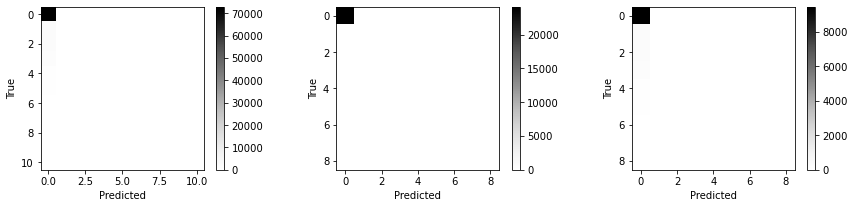

In [188]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], lgbm.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

In [195]:
import joblib
# save model
joblib.dump(lgbm, 'lgb.pkl')
# load model
gbm_pickle = joblib.load('lgb.pkl')

Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?

Высокое значение f1 связано с тем, что большинство полисов будет без выплат, таким образом сложно оценить F1 Score on test: 0.9104679208876025 как хороший, тем более, что на тестовых данных модель классифицирует всего 3 класса: 0,1,9. Возможно нужно бороться с этим с помощью семплирования. Возможно проблема в том, что не все классы попадают в обучающую выборку. 